In [1]:
import pandas as pd
import numpy as np
import cassiopeia as cas
import seaborn as sns
from os.path import join, exists
from os import makedirs, getcwd
from pandarallel import pandarallel
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

pandarallel.initialize(nb_workers=32)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
af_f = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.tsv"
dp_f = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.DP.tsv"
ad_f = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.AD.tsv"
prefix= "TcellDupi_may17_2021/MTblacklist"
name = "post_cass_test"
outdir = "./output/data/"
af_thresh = 0.01
dp_thresh = 2

In [3]:
outdir = join(outdir, prefix)
if not exists(outdir):
    print(f"Making outdir {outdir} in folder {getcwd()}")
    makedirs(outdir)

In [4]:
af = pd.read_csv(af_f, index_col=0, sep='\t')
dp = pd.read_csv(dp_f, index_col=0, sep='\t').astype(int)
ad = pd.read_csv(ad_f, index_col=0, sep='\t').astype(int)


## Create character matrix - binarize af by af_thresh, and set any element under dp_thresh to -1

In [5]:
#Binarize
af = af.applymap(lambda x: 0 if x<af_thresh else 1)
af
#af[af>=af_thresh] = 1
#af = af.loc[dp<dp_thresh] = -1

,1040C,10634C,10646T,1082G,10912A,1095C,11123A,11137C,11175C,11204A,...,9531G,954G,9590T,9640T,9658G,971C,9750A,9823A,983T,9861G
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAACAGGA-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
AAACGAAAGATTGACA-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
AAACGAAAGCGTTGCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGAAAGGTACTCT-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
AAACGAAAGGTTAACA-1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCCGGAAAG-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
TTTGTGTTCCTGACCT-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
TTTGTGTTCGGATGTT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def dp_where(x, dp, dp_thresh):
#    print('name', x.name)
    curr = dp.loc[x.name]<dp_thresh
#     print('curr')
#     print(curr)
    x.loc[curr] = -1 #"-"
    return x

af = af.parallel_apply(dp_where, axis=1, args=(dp,dp_thresh))
# tmp0 = af.head(10).apply(dp_where, axis=1, args=(dp,0))

# tmp10 = af.head(10).apply(dp_where, axis=1, args=(dp,10))
# (tmp0==-1).sum(axis=1)

In [7]:
character_matrix = af.copy()
#character_matrix = af.parallel_apply(dp_where, axis=1, args=(dp,dp_thresh))
character_matrix

,1040C,10634C,10646T,1082G,10912A,1095C,11123A,11137C,11175C,11204A,...,9531G,954G,9590T,9640T,9658G,971C,9750A,9823A,983T,9861G
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAACAGGA-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AAACGAAAGATTGACA-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AAACGAAAGCGTTGCC-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AAACGAAAGGTACTCT-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,-1
AAACGAAAGGTTAACA-1,-1,-1,-1,-1,-1,-1,1,0,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCCGGAAAG-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
TTTGTGTTCCTGACCT-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
TTTGTGTTCGGATGTT-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [8]:
var_map = {val:f"r{i}" for i, val in enumerate(character_matrix.columns) }
character_matrix = character_matrix.rename(var_map, axis=1)

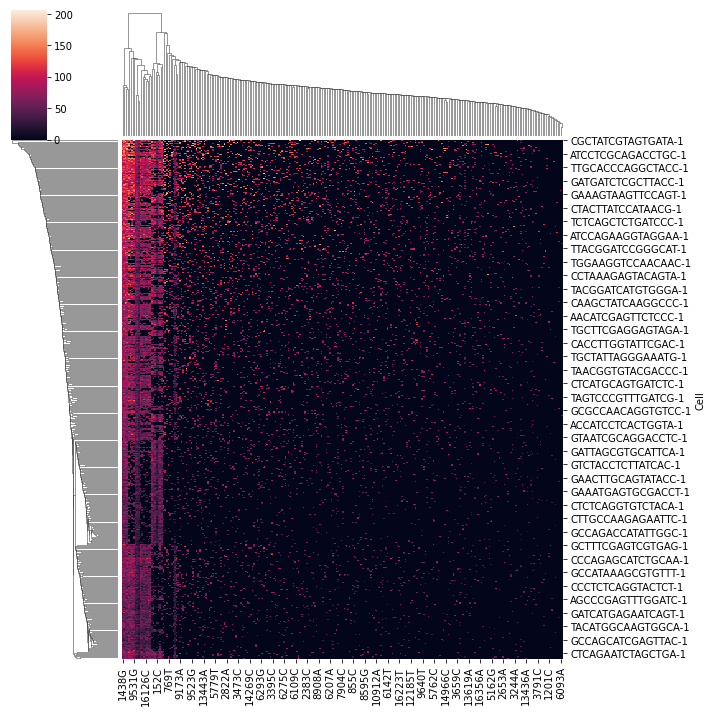

In [9]:
sns.clustermap(dp.sample(n=500))

In [10]:
#indel_priors = cas.pp.compute_empirical_indel_priors(character_matrix.copy().astype(int).sample(n=500), grouping_variables=['Cell'])

In [11]:
#indel_priors.sort_values(by='count', ascending=False).head()


In [12]:
# #CLONE = 45
# CLONE = None
# if CLONE is None:
#     clone_allele_table = allele_table.copy()
# else:
#     clone_allele_table = allele_table[allele_table['LineageGroup'] == CLONE]


In [13]:
# n_cells = clone_allele_table['cellBC'].nunique()
# n_intbc = clone_allele_table['intBC'].nunique()

# print(f"Clonal population #{CLONE} has {n_cells} cells and {n_intbc} intBCs ({n_intbc * 3}) characters.")

In [14]:
# character_matrix, priors, state_2_indel = cas.pp.convert_alleletable_to_character_matrix(clone_allele_table,
#                                                                                          allele_rep_thresh = 0.9,
#                                                                                          mutation_priors = indel_priors)

## Reconstructing Trees

In [15]:
sample_mat = character_matrix.sample(n=100)
sample_mat = sample_mat.loc[:, ~((sample_mat==-1).all(axis=0))]
sample_mat = sample_mat.loc[~((sample_mat==-1).all(axis=1)), :]

var_map = {val:f"r{i}" for i, val in enumerate(sample_mat.columns) }
sample_mat = sample_mat.rename(var_map, axis=1)

sample_mat.to_csv(join(outdir, name+".sample100.tsv"),sep='\t')

sample_mat.shape


(100, 259)

In [16]:
priors=None
if priors is not None:
    cas_tree = cas.data.CassiopeiaTree(character_matrix=sample_mat, priors=priors)
else:
    cas_tree = cas.data.CassiopeiaTree(character_matrix=sample_mat)
cas_tree.character_matrix.head(5)


,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,r249,r250,r251,r252,r253,r254,r255,r256,r257,r258
Cell,,,,,,,,,,,,,,,,,,,,,
GCGGAAACAGGTGGTA-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
TACTCGCTCCAATAGC-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,1,-1,-1,-1,-1
TAGCATGCATGTAGAA-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
TTGTCTAGTGAGCTAG-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
CCGCATTTCTAGCAGT-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1


In [17]:
cas_tree.n_cell, cas_tree.n_character,


(100, 259)

In [18]:
# cell_meta = clone_allele_table.groupby('cellBC').agg({"intBC": 'nunique', 'UMI': 'sum', 'sampleID': 'unique'})
# cell_meta['sampleID'] = [x[0] for x in cell_meta['sampleID']]

# missing_proportion = (character_matrix == -1).sum(axis=0) / character_matrix.shape[0]
# uncut_proportion = (character_matrix == 0).sum(axis=0) / character_matrix.shape[0]
# n_unique_states = character_matrix.apply(lambda x: len(np.unique(x[(x != 0) & (x != -1)])), axis=0)

# character_meta = pd.DataFrame([missing_proportion, uncut_proportion, n_unique_states], index = ['missing_prop', 'uncut_prop', 'n_unique_states']).T

# cas_tree.cell_meta = cell_meta
# cas_tree.character_meta = character_meta

In [19]:
# create a basic vanilla greedy solver
vanilla_greedy = cas.solver.VanillaGreedySolver()

# reconstruct the tree
vanilla_greedy.solve(cas_tree, collapse_mutationless_edges=True)

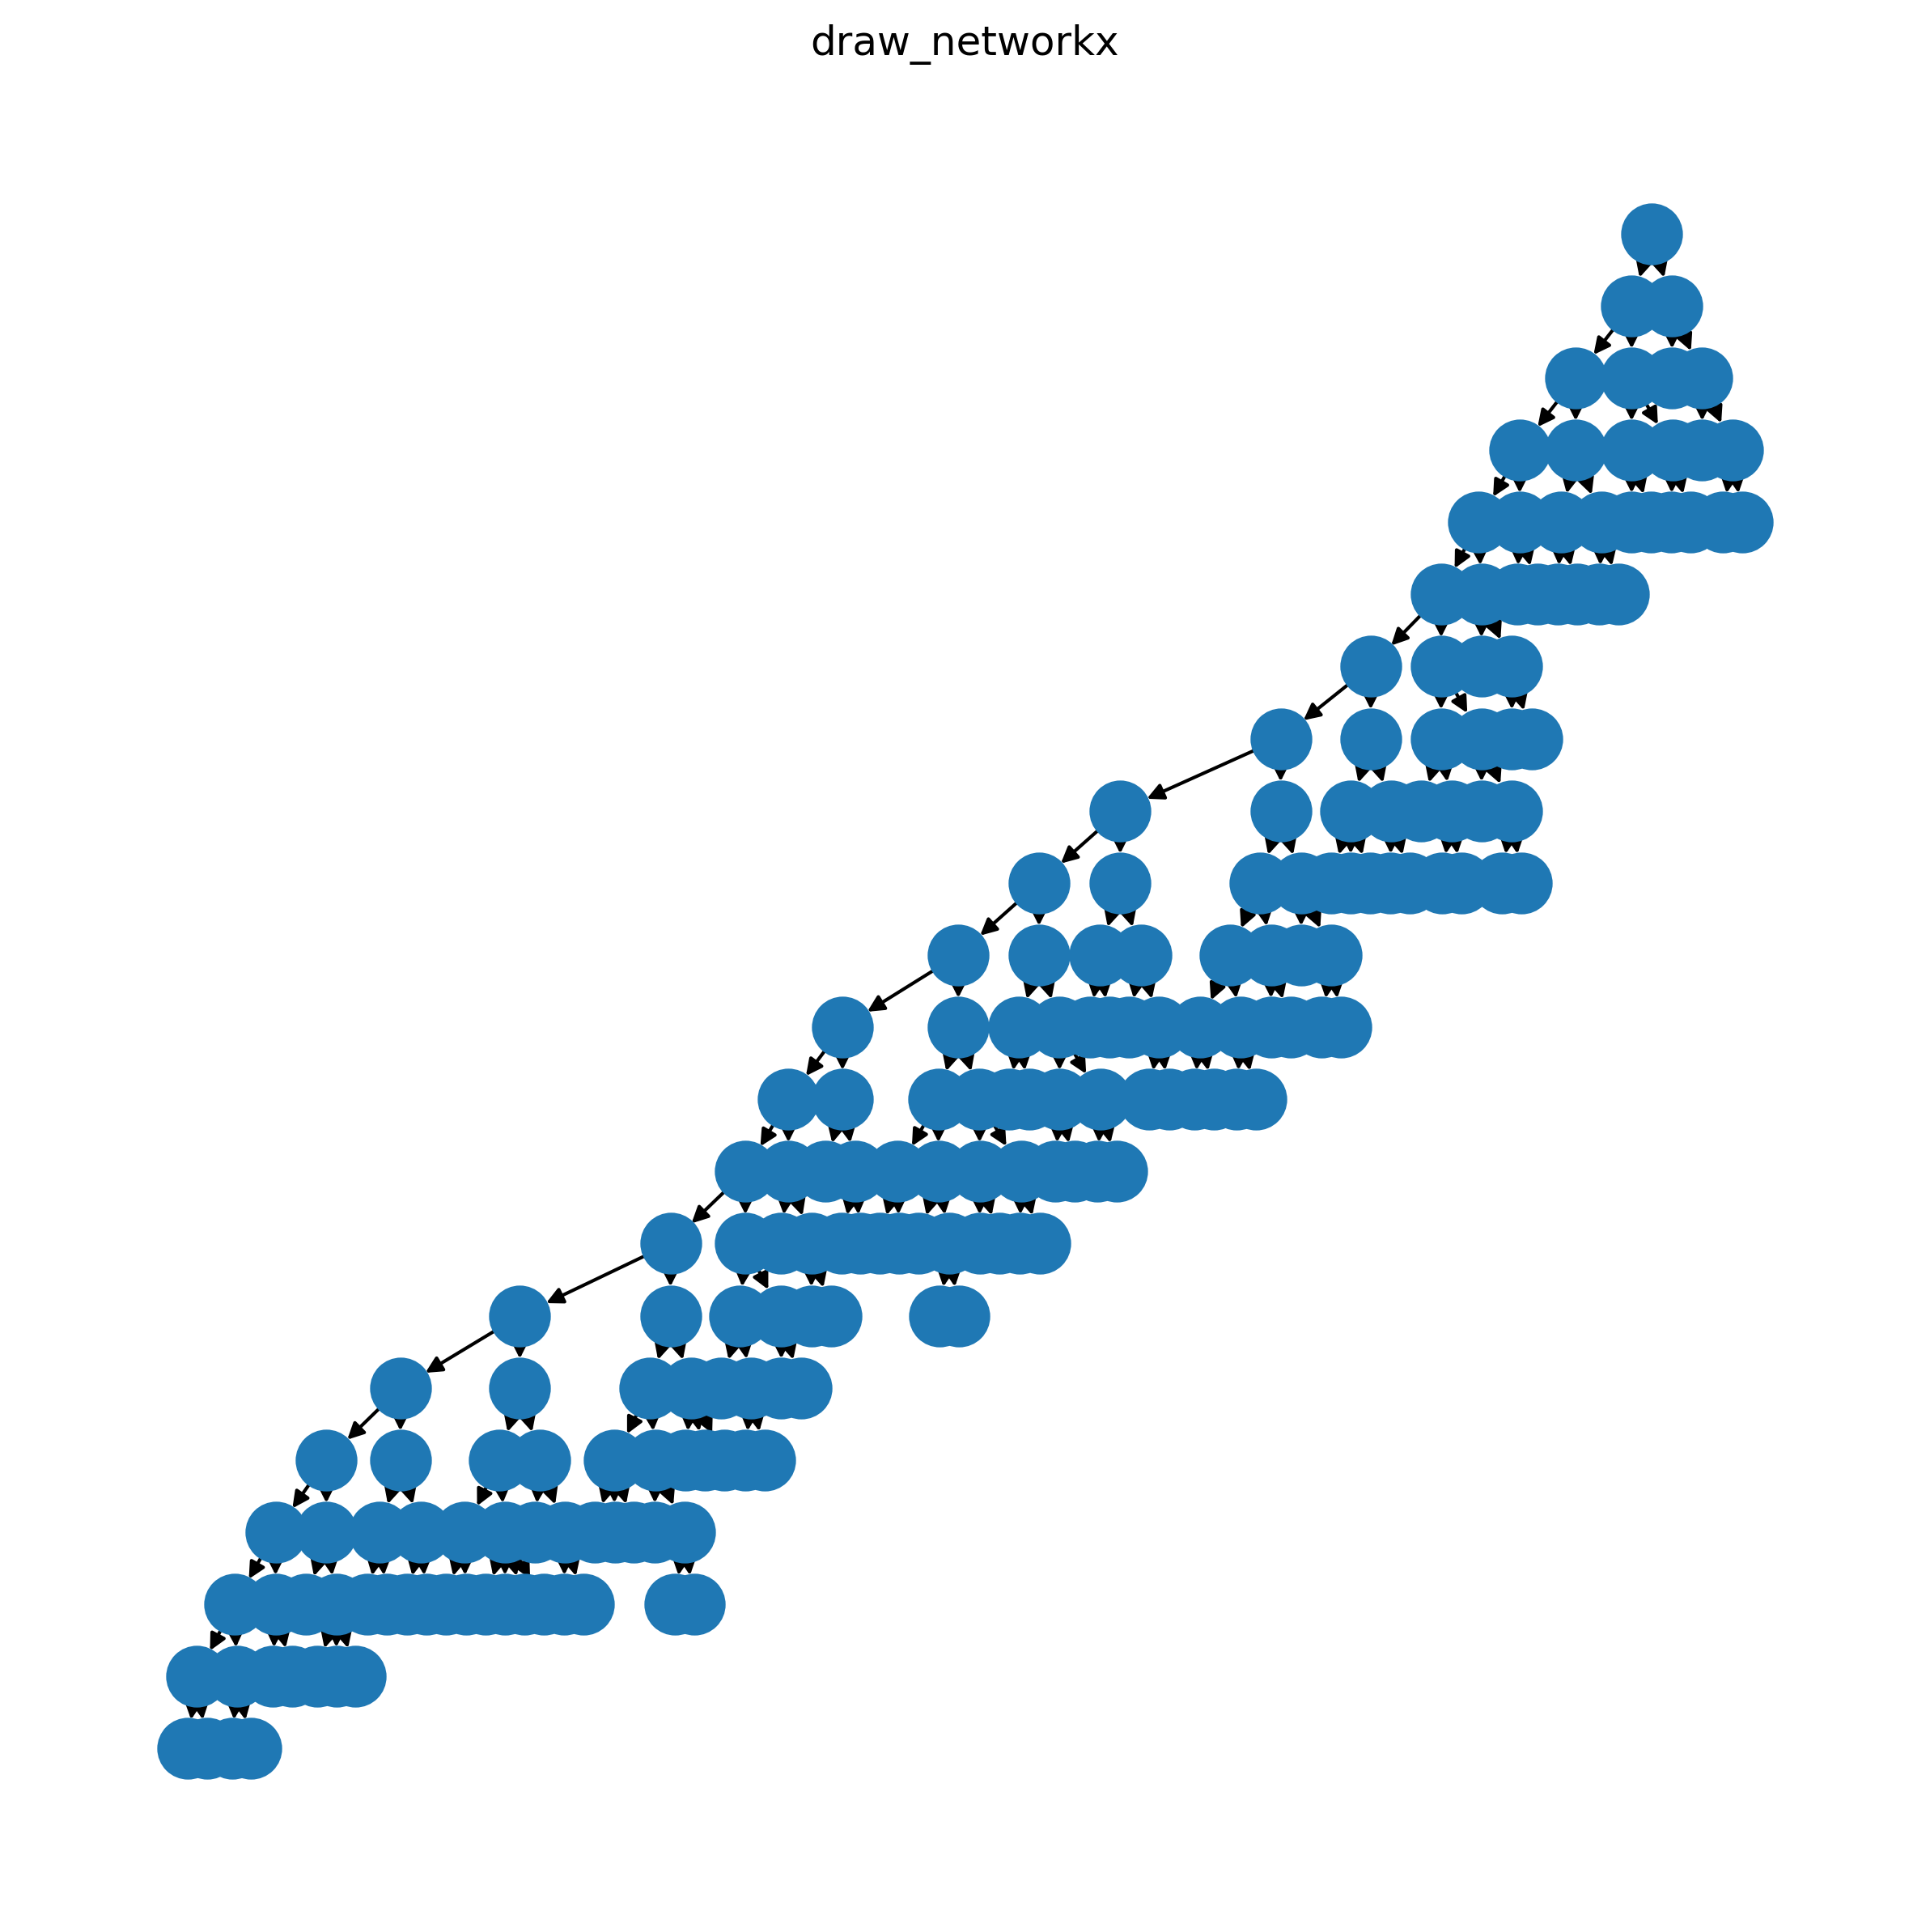

In [20]:
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_nodes_from(cas_tree.nodes)
G.add_edges_from(cas_tree.edges)
G

# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"

f = plt.figure(figsize=(10,10), dpi=300)
write_dot(G,join(outdir, f'{name}_greedy.dot'))


# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos = graphviz_layout(G, prog='dot', root=cas_tree.root)
nx.draw(G, pos, with_labels=False, arrows=True)
plt.savefig(join(outdir, f'{name}_greedy.png'))

In [21]:
if priors is not None:
    ilp_solver = cas.solver.ILPSolver(convergence_time_limit=500, maximum_potential_graph_layer_size=500, weighted=True, seed=1234)
else:
    ilp_solver = cas.solver.ILPSolver(convergence_time_limit=500, maximum_potential_graph_layer_size=500, weighted=False, seed=1234)
ilp_solver.solve(cas_tree)


[2021-08-10 01:43:13,323]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-10 01:43:13,324]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-10 01:43:13,325]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-10 01:43:13,326]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-10 01:43:13,327]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-10 01:43:13,328]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-10 01:43:15,214]    INFO [ILPSolver] (Process: fcea3401d501dbbb34fe30d0470cec91) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 63.
[2021-08-10 01:43:18,159]    INFO [ILPSolver] (Process: fcea3401d501dbbb34fe30d0470cec91) Maximum layer size exceeded, returning network.


KeyError: (-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, 1, -1, -1, 0, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -1, -1, -1, 0, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

In [ ]:
!head -50 stdout.log


In [ ]:
G = nx.DiGraph()
G.add_nodes_from(cas_tree.nodes)
G.add_edges_from(cas_tree.edges)
G

# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

f = plt.figure(figsize=(10,10), dpi=300)
write_dot(G,join(outdir, f'{name}_ilp.dot'))


# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos = graphviz_layout(G, prog='dot', root=cas_tree.root)
nx.draw(G, pos, with_labels=False, arrows=True)
plt.savefig(join(outdir, f'{name}_ilp.png'))

## HybridSolver 
1. Top-down greedy solver followed by
2. Bottom-solve of any tipe. 

In [ ]:
# REINSTANTIATE the bottom and top solvers
vanilla_greedy = cas.solver.VanillaGreedySolver()
if priors is not None:
    ilp_solver = cas.solver.ILPSolver(convergence_time_limit=500, maximum_potential_graph_layer_size=500, weighted=True, seed=1234)
else:
    ilp_solver = cas.solver.ILPSolver(convergence_time_limit=500, maximum_potential_graph_layer_size=500, weighted=False, seed=1234)


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# hybrid_solver = cas.solver.HybridSolver(top_solver=vanilla_greedy, bottom_solver=ilp_solver, cell_cutoff=40, threads=10)
# hybrid_solver.solve(cas_tree, logfile='hybrid.log')
hybrid_solver = cas.solver.HybridSolver(top_solver=vanilla_greedy, bottom_solver=ilp_solver, cell_cutoff=40, threads=10)
hybrid_solver.solve(cas_tree, logfile='example_hybrid.log')


In [ ]:
!ls | grep 'example_hybrid'


In [ ]:
rndict = {}
_iter = 0
for n in cas_tree.nodes:
    if ',' in n:
        rndict[n] = f'node{_iter}'
        _iter += 1

cas_tree.relabel_nodes(rndict)

In [ ]:
pickle.dump(cas_tree, open(join(outdir, name+".castree.p"), 'wb'))

# Plot tree 

## Plot with networkx


In [ ]:

G = nx.DiGraph()
G.add_nodes_from(cas_tree.nodes)
G.add_edges_from(cas_tree.edges)
G

# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"

f = plt.figure(figsize=(10,10), dpi=300)
write_dot(G,join(outdir, f'{name}_hybrid.dot'))


# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos = graphviz_layout(G, prog='dot', root=cas_tree.root)
nx.draw(G, pos, with_labels=False, arrows=True)
plt.savefig(join(outdir, f'{name}_hybrid.png'))


## Plot with itol (only with valid itol account)

In [ ]:
# plot tree
cas.pl.upload_and_export_itol(cas_tree, itol_config="~/.itolconfig_hidden",
                              tree_name = "example_hybrid_tree", export_filepath="example_hybrid_tree.png")
